### A/B Testing

In [33]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [34]:
# loading the results of our experiment
df_raw = pd.read_csv("data/ab_data.csv")

In [35]:
df_raw.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
# let's make a copy of the df to manipulate freely 
df = df_raw.copy()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [38]:
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [39]:
# converting dtype for "timestamp" and extract the date for easy handling
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.date
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [40]:
# and checking how many observations we have for each possible combination
df.groupby(["group", "landing_page"], as_index=False).size()

,group,landing_page,size
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


I notice some inconsistencies that I will now filter out. In this case, the control group should only see the "old_page" and treatment group should only see the "new_page".
These are not too many cases but, in a real case scenario, I would inform the developers who set the experiment up as they might notice some bugs in the way the experiment was built.

In [41]:
df = df[(df.group=="control")&(df.landing_page=="old_page") | (df.group=="treatment")&(df.landing_page=="new_page")] 
df.groupby(["group", "landing_page"], as_index=False).size()

,group,landing_page,size
0,control,old_page,145274
1,treatment,new_page,145311


In [42]:
# double-checking that each user ID is showing up once 
df["user_id"].value_counts()

user_id
773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: count, Length: 290584, dtype: int64

In [43]:
# I found one user who appears twice in this experiment
df[df["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09,treatment,new_page,0
2893,773192,2017-01-14,treatment,new_page,0


In [44]:
# so I will drop the oldest record of them
df = df.drop(df[(df["user_id"] == 773192) & (df["timestamp"] == pd.to_datetime("2017-01-09").date())].index)
df[df["user_id"]==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14,treatment,new_page,0


Now we are ready to visualize our experiment results:

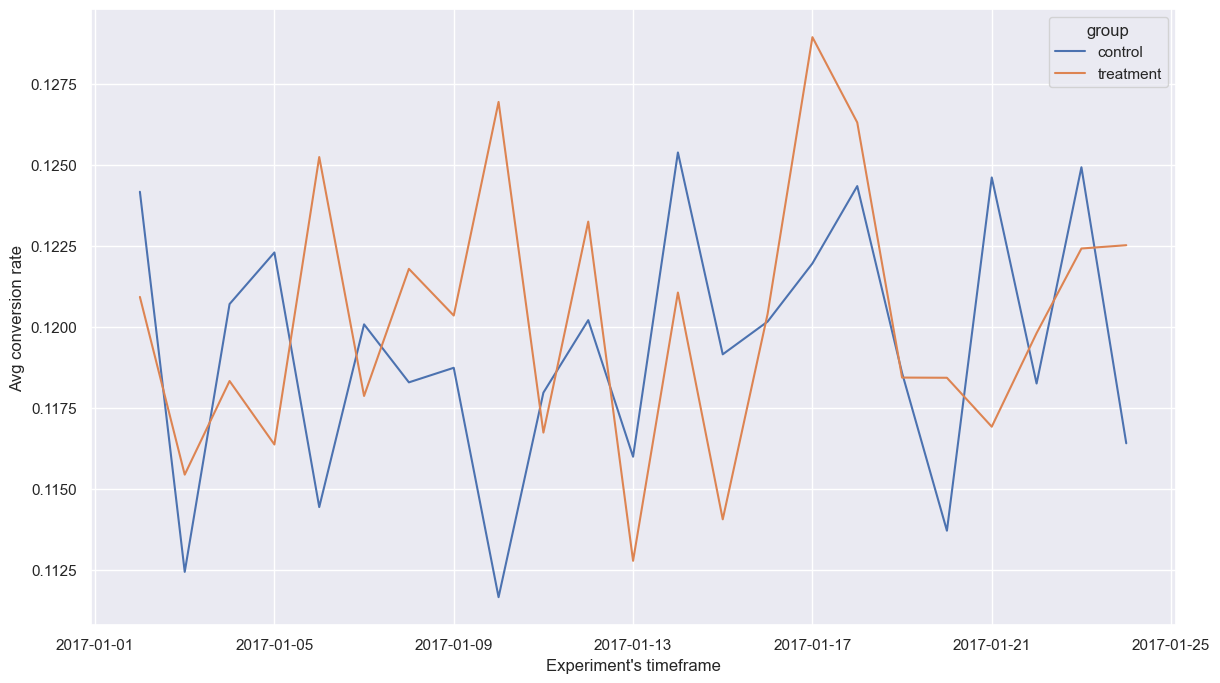

In [45]:
fig, ax = plt.subplots(figsize=(14, 8))
results = sns.lineplot(x="timestamp", y="converted", hue="group", data=df, errorbar=None)
results.set_xlabel("Experiment's timeframe")
results.set_ylabel("Avg conversion rate")
plt.show()

And get a summary table with basic statistics:

In [46]:
df.groupby("group", as_index=False).agg({"converted": ["count", "sum", "mean"]})

group converted                 
                 count    sum      mean
0    control    145274  17325  0.119257
1  treatment    145310  17464  0.120184

From this, we can see that:
- The minimum sample size (16154 per group) has been reached.
- Both control and treatment groups have more or less the same sample size. This means that our 50% traffic split worked.
- When looking at conversions, the treatment group seems to have performed better than the control group. This means that the new page seems to be performing better than the old page.
- But is this result statistically significant? We will perform a permutation test to assess it.

### Permutation test

*H0: treatment's conversion rate <= control's conversion rate //
H1: treatment's conversion rate > control's conversion rate*

In [47]:
mu_control = np.mean(df[df.group=="control"]["converted"])
mu_treatment = np.mean(df[df.group=="treatment"]["converted"])
mu_diff = mu_treatment - mu_control
print("Observed test statistic:", mu_diff)

Observed test statistic: 0.0009270300287862882


Now we can proceed with our permutations, which in this case we set at n = 2000:

In [48]:
n = 2000
mu_diff_samples = []
for i in range(n): 
    df_sample1 = df.sample(frac=0.5, replace=False)
    ix2 = set(df.index) - set(df_sample1.index)
    df_sample2 = df.loc[list(ix2)]
    mu_diff_temp = np.mean(df_sample1["converted"]) - np.mean(df_sample2["converted"])
    mu_diff_samples.append(mu_diff_temp)

Let's visualize our results:

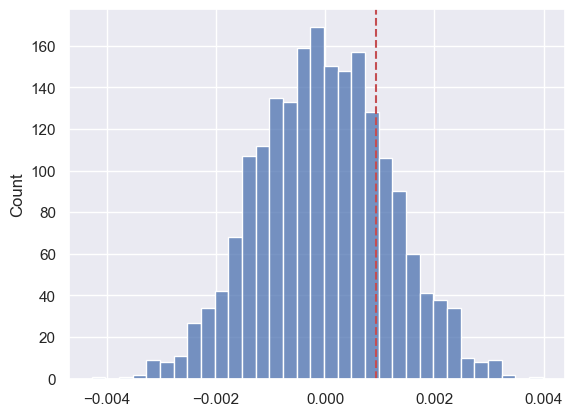

mu_diff: 0.0009270300287862882


In [49]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color="r", linestyle="--")
plt.show()
print("mu_diff:", mu_diff)

In [50]:
print("Values more extreme than observed:", sum([el >= mu_diff for el in mu_diff_samples]))
print("Total results:", len(mu_diff_samples))
p_value = sum([el > mu_diff for el in mu_diff_samples])/n
print("p-value:", p_value)

Values more extreme than observed: 427
Total results: 2000
p-value: 0.2135


In [51]:
alpha = 0.05 # we set our alpha level at 5%
if p_value <= alpha: 
    print("H0 rejected: the observed result is statistically significant | p-value <= alpha")
else: 
    print("H0 accepted | the observed result is not statistically significant | p-value > alpha")

H0 accepted | the observed result is not statistically significant | p-value > alpha
